In [1]:
import os
import torch
import torch.distributed as dist
import sys
sys.path.append(os.path.expanduser("~"))
from utils import compute_pk, draw_figure
from camel_dataloader import get_astro_data_2D_from_3D, get_astro_data, applyTF_2D, Normalize, Stack
from TF_utils import power_spectrum, getGrid, getPkRatios, getGP_post_fit, getGP_post_fit, getCrossCorrelations
import comet_ml
import torch
from torch import nn
from torch.nn.functional import mse_loss
from torch import autograd, Tensor
from lightning.pytorch import LightningModule, Trainer, seed_everything
from lightning.pytorch.loggers import CometLogger
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from typing import Optional, Tuple
from torch.special import expm1
from tqdm import trange
from torch.distributions.normal import Normal
import numpy as np
from matplotlib.ticker import FormatStrFormatter
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import Pk_library as PKL

In [2]:
seed_everything(7, workers=True)
cropsize = 256
batch_size = 12
num_workers = 8
   
dataset = 'Astrid'
learning_rate = 1e-3 #1e-4

[rank: 0] Seed set to 7


# DM in hydro & nbody

In [ ]:
train_dir = '/pscratch/sd/l/lindajin/CAMELS/'
mass_mtot_3D = np.load(train_dir+
    'Grids_Mtot_Astrid_LH_256_z=0.0.npy'
)
mass_cdm_3D = np.load(train_dir+
    'Grids_Mtot_Nbody_Astrid_LH_256_z=0.0.npy'
)
mass_cdm_hydro_3D =  np.load(train_dir+
    'Grids_Mcdm_Astrid_LH_256_z=0.0.npy'
)

In [5]:
print(mass_cdm.shape, mass_cdm_hydro.shape)

(1000, 256, 256, 256) (1000, 256, 256, 256)


In [3]:
mass_mtot =  mass_mtot_3D.mean(axis = -1)
mass_cdm = mass_cdm_3D.mean(axis = -1)
mass_cdm_hydro = mass_cdm_hydro_3D.mean(axis = -1)
mass_baryon = mass_mtot - mass_cdm_hydro

In [4]:
mean_mtot = np.mean(mass_mtot, axis=(1, 2)).reshape(-1, 1, 1)
mean_cdm = np.mean(mass_cdm, axis=(1, 2)).reshape(-1, 1, 1)
mean_cdm_hydro = np.mean(mass_cdm_hydro, axis=(1, 2)).reshape(-1, 1, 1)
mean_baryon = np.mean(mass_baryon, axis=(1, 2)).reshape(-1, 1, 1)


overdensity_mtot = mass_mtot / mean_mtot - 1
overdensity_cdm = mass_cdm / mean_cdm - 1
overdensity_cdm_hydro = mass_cdm_hydro / mean_cdm_hydro - 1
overdensity_baryon = mass_baryon / mean_baryon - 1

In [12]:
grid    = 256     #the map will have grid^2 pixels
BoxSize = 25 #Mpc/h
MAS     = 'None'  #MAS used to create the image; 'NGP', 'CIC', 'TSC', 'PCS' o 'None'
threads = 1       #number of openmp threads
axis = 0
verbose = False

P_mtot = PKL.Pk_plane(overdensity_mtot[30], BoxSize, MAS, threads, verbose)
P_nbody = PKL.Pk_plane(overdensity_cdm[30], BoxSize,  MAS, threads, verbose)
P_cdm = PKL.Pk_plane(overdensity_cdm_hydro[30], BoxSize, MAS, threads, verbose) 
P_baryon = PKL.Pk_plane(overdensity_baryon[30], BoxSize, MAS, threads, verbose) 

k   = P_mtot.k
P_mtot   = P_mtot.Pk
K   = P_nbody.k
P_nbody   = P_nbody.Pk
K   = P_cdm.k
P_cdm   = P_cdm.Pk
K   = P_baryon.k
P_baryon   = P_baryon.Pk


#post-fit Cross-correlation -- more wiggly, slightly under saved Rcc from k~8
Pkcc = PKL.XPk_plane(overdensity_cdm[30],overdensity_cdm_hydro[30],  BoxSize, MAS,MAS, threads=1) 
kcc   = Pkcc.k
Rcc = Pkcc.r
Pkcc = PKL.XPk_plane(overdensity_baryon[30],overdensity_cdm_hydro[30],  BoxSize, MAS,MAS, threads=1) 
Rcc_baryons = Pkcc.r
Pkcc = PKL.XPk_plane(overdensity_mtot[30],overdensity_cdm_hydro[30],  BoxSize, MAS,MAS, threads=1) 
Rcc_cdm = Pkcc.r
Pkcc = PKL.XPk_plane(overdensity_mtot[30],overdensity_cdm[30],  BoxSize, MAS,MAS, threads=1) 
Rcc_nbody = Pkcc.r
Pkcc = PKL.XPk_plane(overdensity_baryon[30],overdensity_cdm[30],  BoxSize, MAS,MAS, threads=1) 
Rcc_baryons_nbody = Pkcc.r


Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds


In [8]:
sim='Astrid'
s='LH'
res=256
z='0.0'
k, PkRatios = getPkRatios(sim, s, res, z)
mask_2 = k[0] <= 10
filtered_k = k[:, mask_2]
filtered_PkRatios = PkRatios[:, mask_2]
post_fit_ratios = getGP_post_fit(sim, s, res, z, smoothed=False)
distances = np.linalg.norm(post_fit_ratios - filtered_PkRatios[30], axis=1)
post_fit_index = np.argmin(distances)

CC_k, CC = getCrossCorrelations(sim, s, res, z)
mask_3 = CC_k <= 10
filtered_CC_k = CC_k[mask_3]
filtered_CC = CC[:, mask_3]

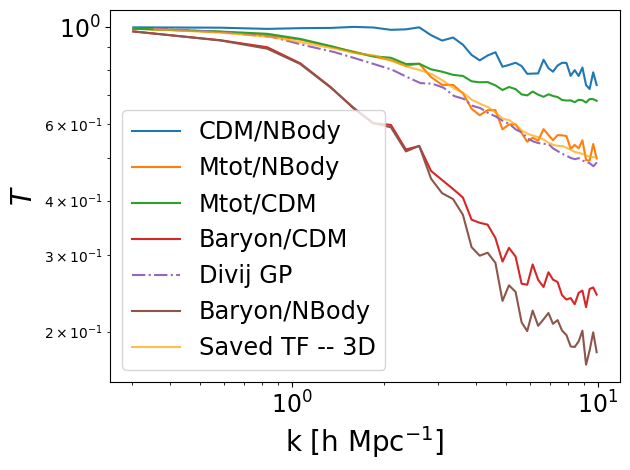

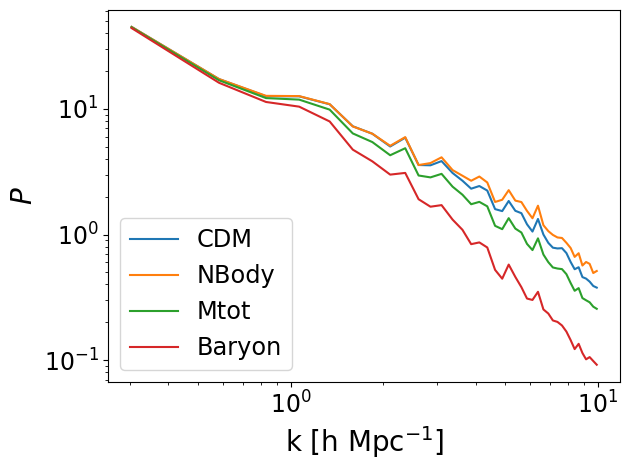

In [11]:
mask = kcc <= 10
plt.plot(kcc[mask], (P_cdm/P_nbody)[mask], label='CDM/NBody')
plt.plot(kcc[mask], (P_mtot/P_nbody)[mask], label='Mtot/NBody')
plt.plot(kcc[mask], (P_mtot/P_cdm)[mask], label='Mtot/CDM')
plt.plot(kcc[mask], (P_baryon/P_cdm)[mask], label='Baryon/CDM')
plt.plot(filtered_k[0], post_fit_ratios[post_fit_index],'-.',  label='Divij GP')
plt.plot(kcc[mask], (P_baryon/P_nbody)[mask], label='Baryon/NBody')
plt.plot(filtered_k[0], filtered_PkRatios[30], label='Saved TF -- 3D', c='orange',alpha = 0.7)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'k [h Mpc$^{-1}$]', fontsize=20)
plt.ylabel(r'$T$', fontsize=20)
plt.legend(fontsize='xx-large')
plt.tight_layout()     
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.tight_layout()
plt.show()

mask = k <= 10
plt.figure()
plt.plot(k[mask], P_cdm[mask], label='CDM')
plt.plot(k[mask], P_nbody[mask], label='NBody')
plt.plot(k[mask], P_mtot[mask], label='Mtot')
plt.plot(k[mask], P_baryon[mask], label='Baryon')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'k [h Mpc$^{-1}$]', fontsize=20)
plt.ylabel(r'$P$', fontsize=20)
plt.legend(fontsize='xx-large')
plt.tight_layout()     
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.tight_layout()
plt.show()

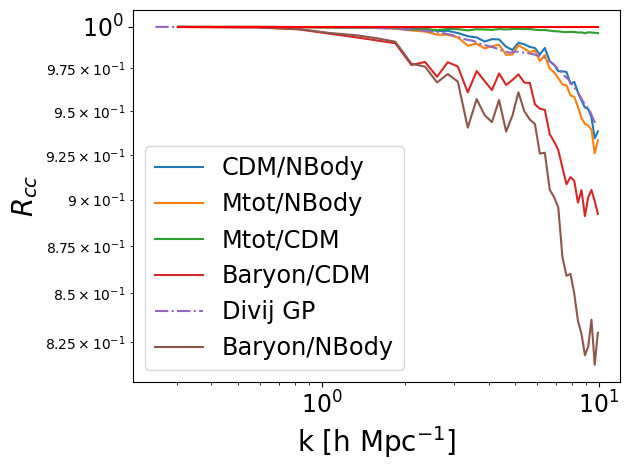

In [13]:
plt.figure()
mask = kcc <= 10
plt.plot(kcc[mask], Rcc[mask], label='CDM/NBody')
plt.plot(kcc[mask], Rcc_nbody[mask], label='Mtot/NBody')   
plt.plot(kcc[mask], Rcc_cdm[mask], label='Mtot/CDM')
plt.plot(kcc[mask], Rcc_baryons[mask], label='Baryon/CDM')   
plt.plot(filtered_CC_k,filtered_CC[30],'-.', label = 'Divij GP')
plt.plot(kcc[mask], Rcc_baryons_nbody[mask], label='Baryon/NBody')   
plt.plot(kcc[mask], np.ones_like(kcc[mask]),'r','--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'k [h Mpc$^{-1}$]', fontsize=20)
plt.ylabel(r'$R_{cc}$', fontsize=20)
plt.legend(fontsize='xx-large')
plt.tight_layout()     
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.tight_layout()
plt.show()

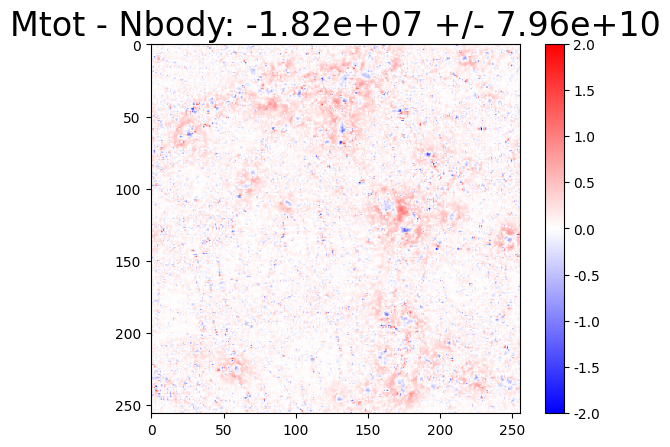

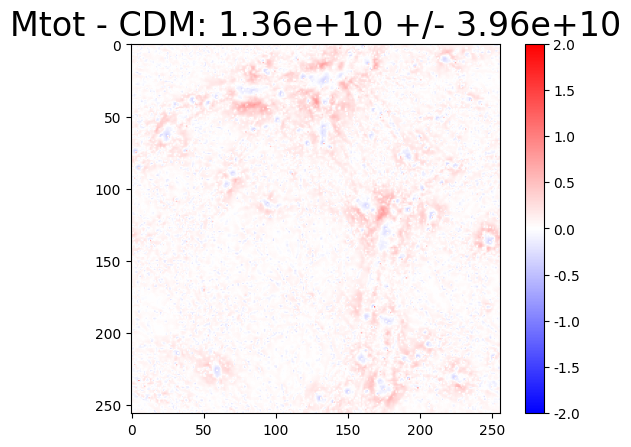

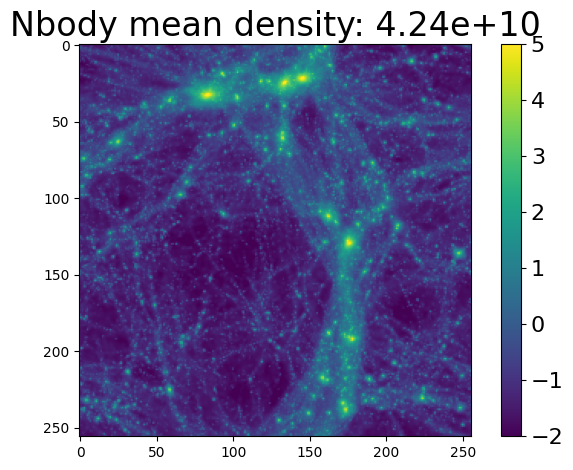

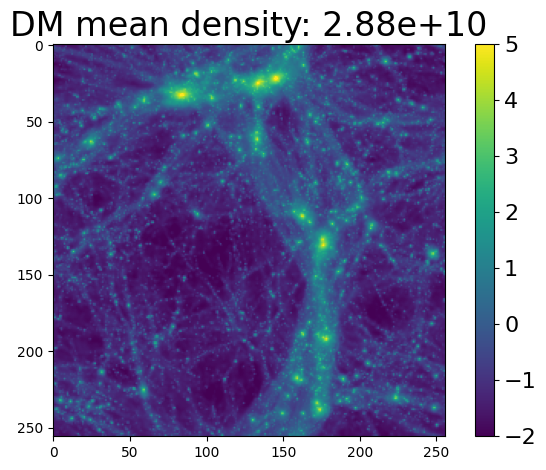

In [26]:
m_delta_log = np.log(overdensity_mtot[30]+1) - np.log(overdensity_cdm[30]+1)
colors = [(0, 'blue'), (0.5, 'white'), (1, 'red')]
cmap = LinearSegmentedColormap.from_list('custom', colors)
vmin = -2.0
vmax = 2.0
plt.figure()
im = plt.imshow(m_delta_log,  cmap=cmap, vmin=vmin, vmax=vmax)
cbar = plt.colorbar(im, format=FormatStrFormatter('%.1f'))
plt.title(f'Mtot - Nbody: {(mass_mtot[30]-mass_cdm[30]).mean():.2e} +/- {(mass_mtot[30]-mass_cdm[30]).std():.2e}', fontsize=24)
plt.show()

m_delta_log = np.log(overdensity_mtot[30]+1) - np.log(overdensity_cdm_hydro[30]+1)
colors = [(0, 'blue'), (0.5, 'white'), (1, 'red')]
cmap = LinearSegmentedColormap.from_list('custom', colors)
vmin = -2.0
vmax = 2.0
plt.figure()
im = plt.imshow(m_delta_log,  cmap=cmap, vmin=vmin, vmax=vmax)
cbar = plt.colorbar(im, format=FormatStrFormatter('%.1f'))
plt.title(f'Mtot - CDM: {(mass_mtot[30]-mass_cdm_hydro[30]).mean():.2e} +/- {(mass_mtot[30]-mass_cdm_hydro[30]).std():.2e}', fontsize=24)
plt.show()

plt.figure()
plt.imshow(np.log(overdensity_cdm[30]+1), cmap='viridis', vmin=-2, vmax=5)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.title(f'Nbody mean density: {mass_cdm[30].mean():.2e}', fontsize=24)
plt.tight_layout()
plt.show()

plt.figure()
plt.imshow(np.log(overdensity_cdm_hydro[30]+1), cmap='viridis', vmin=-2, vmax=5)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.title(f'DM mean density: {mass_cdm_hydro[30].mean():.2e}', fontsize=24)
plt.tight_layout()
plt.show()



## Check if TF is applied properly in 2D -- Yes! (diff performance for each map)

In [31]:
m_cdm, m_cdm_tf, m_mtot = next(iter(dm_2D.test_dataloader()))
def plot_Pk_postTF(m_cdm, m_cdm_tf, m_mtot): #in overdensity (256,256)
    BoxSize = 25
    grid    = 256     #the map will have grid^2 pixels
    MAS     = 'None'  #MAS used to create the image; 'NGP', 'CIC', 'TSC', 'PCS' o 'None'
    threads = 1       #number of openmp threads
    axis = 0
    verbose = True
    Pk2D_hydro = PKL.Pk_plane(m_mtot.reshape(256,256).detach().cpu().numpy().astype(np.float32), BoxSize, MAS, threads, verbose)
    Pk2D_Nbody = PKL.Pk_plane(m_cdm.reshape(256,256).detach().cpu().numpy().astype(np.float32), BoxSize,  MAS, threads, verbose)
    Pk2D_postTF = PKL.Pk_plane(m_cdm_tf.reshape(256,256).detach().cpu().numpy().astype(np.float32), BoxSize, MAS, threads, verbose) #dosent look right ~Nbody
    k_Hydro   = Pk2D_hydro.k
    Pk_Hydro   = Pk2D_hydro.Pk
    k_NBody   = Pk2D_Nbody.k
    Pk_NBody   = Pk2D_Nbody.Pk
    k_postTF   = Pk2D_postTF.k
    Pk_postTF   = Pk2D_postTF.Pk

    plt.figure()
    mask = k_Hydro <= 10
    plt.plot(k_Hydro[mask], Pk_Hydro[mask], label='Hydro')
    plt.plot(k_NBody[mask], Pk_NBody[mask], label='NBody')
    plt.plot(k_postTF[mask], Pk_postTF[mask], label='postTF')    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'k [h Mpc$^{-1}$]', fontsize=20)
    plt.ylabel(r'P(k)', fontsize=20)
    plt.legend(fontsize='xx-large')
    plt.tight_layout()     
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)
    plt.tight_layout()
    plt.show()

In [10]:
import importlib
import camel_dataloader

importlib.reload(camel_dataloader) 
from camel_dataloader import applyTF_2D

cuda
4


0.972044
0.972044
0.95670104
0.95670104
0.6425476

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds


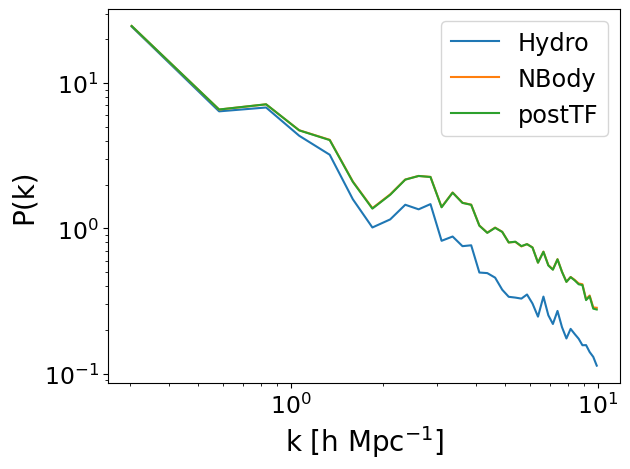


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds


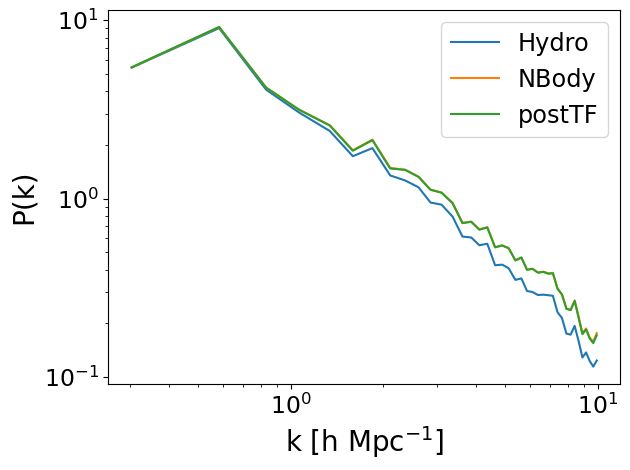


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds


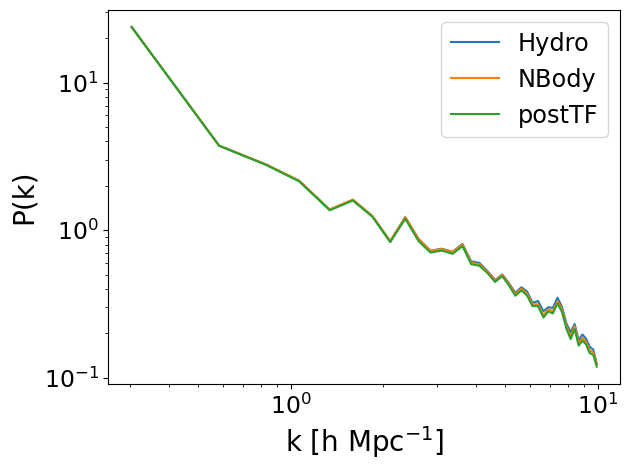


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds


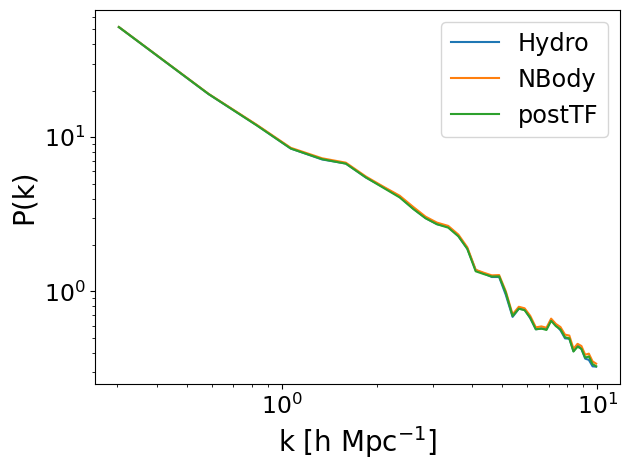


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds


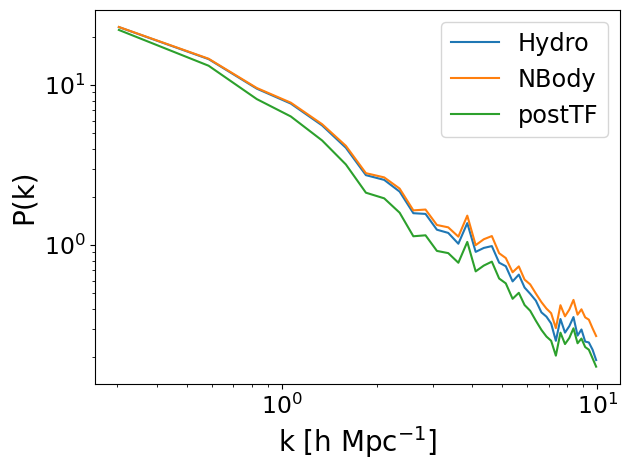

In [23]:
applyTF_train=applyTF_2D(boxsize=25.0, sim= dataset,res = 256, s= 'LH', redshift= '0.0')
post_TF0 = applyTF_train(m_cdm[0].reshape(256,256)-1,0)
post_TF2 = applyTF_train(m_cdm[2].reshape(256,256)-1,2) #//3 have same ratios
post_TF5 = applyTF_train(m_cdm[5].reshape(256,256)-1,5)
post_TF3 = applyTF_train(m_cdm[3].reshape(256,256)-1,3)
post_TF10 = applyTF_train(m_cdm[10].reshape(256,256)-1,10)

plot_Pk_postTF(m_cdm[0]-1, post_TF0, m_mtot[0]-1)
plot_Pk_postTF(m_cdm[2]-1, post_TF2, m_mtot[2]-1)
plot_Pk_postTF(m_cdm[5]-1, post_TF5, m_mtot[5]-1)
plot_Pk_postTF(m_cdm[3]-1, post_TF3, m_mtot[3]-1)
plot_Pk_postTF(m_cdm[10]-1, post_TF10, m_mtot[10]-1)

In [28]:
def plot_residual_fields(sim_indx):
    diff = np.log(m_mtot[sim_indx]) - np.log(m_cdm_tf[sim_indx])
    plt.figure()
    colors = [(0, 'blue'), (0.5, 'white'), (1, 'red')]
    cmap = LinearSegmentedColormap.from_list('custom', colors)
    im = plt.imshow(diff.reshape(256,256), cmap=cmap, vmin=-2, vmax=2)
    cbar = plt.colorbar(im, format=FormatStrFormatter('%.1f'))
    cbar.ax.tick_params(labelsize=16)
    plt.title(f'Hydro - postTF: {diff.mean():.2e} +/- {diff.std():.2e}', fontsize=24)
    plt.tight_layout()
    plt.show()

    diff = np.log(m_mtot[sim_indx]) - np.log(m_cdm[sim_indx])
    plt.figure()
    im = plt.imshow(diff.reshape(256,256), cmap=cmap, vmin=-2, vmax=2)
    cbar = plt.colorbar(im, format=FormatStrFormatter('%.1f'))
    cbar.ax.tick_params(labelsize=16)
    plt.title(f'Hydro - NBody: {diff.mean():.2e} +/- {diff.std():.2e}', fontsize=24)
    plt.tight_layout()
    plt.show()

    plt.figure()
    im = plt.imshow(np.log(m_cdm[sim_indx].reshape(256,256).squeeze().cpu()), cmap='viridis', vmin=-2, vmax=5)
    cbar = plt.colorbar(im, format=FormatStrFormatter('%.1f'))
    cbar.ax.tick_params(labelsize=16)
    plt.title(f'map_DM: {m_cdm.mean():.2e} +/- {m_cdm.std():.2e}', fontsize=24)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_32375/4177219702.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  diff = np.log(m_mtot[sim_indx]) - np.log(m_cdm_tf[sim_indx])


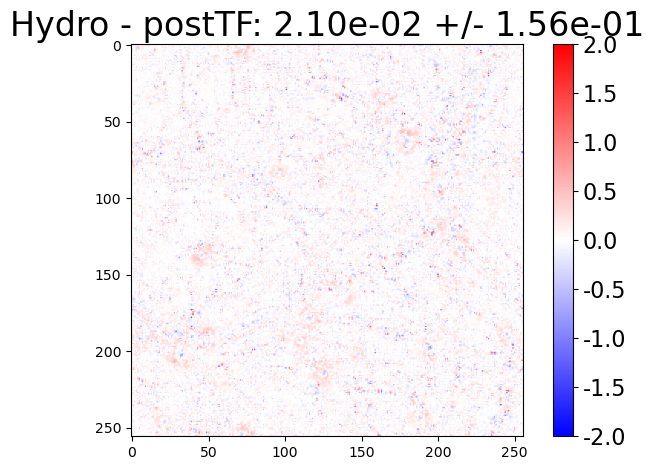

/tmp/ipykernel_32375/4177219702.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  diff = np.log(m_mtot[sim_indx]) - np.log(m_cdm[sim_indx])


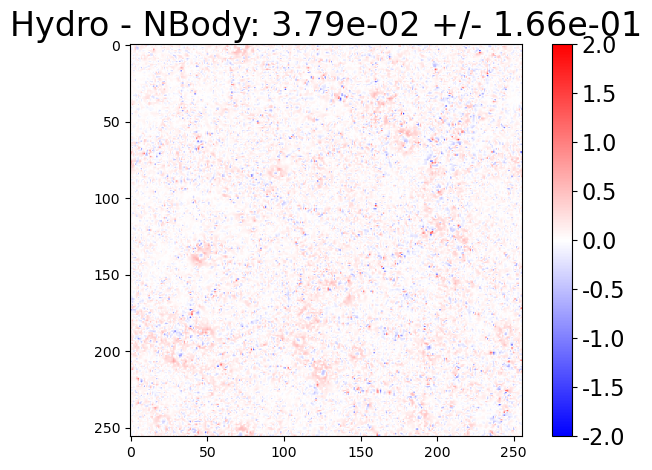

/tmp/ipykernel_32375/4177219702.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  im = plt.imshow(np.log(m_cdm[sim_indx].reshape(256,256).squeeze().cpu()), cmap='viridis', vmin=-2, vmax=5)


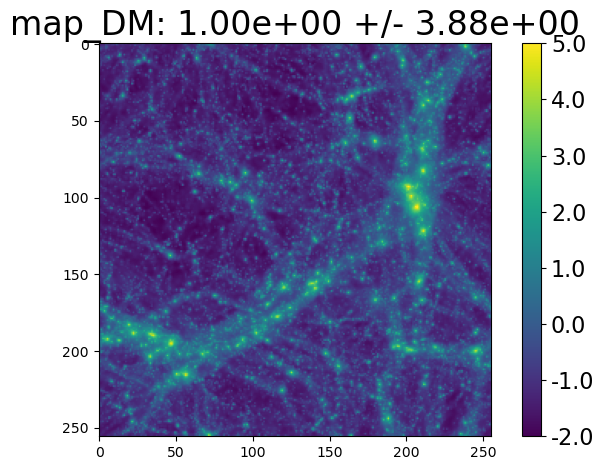

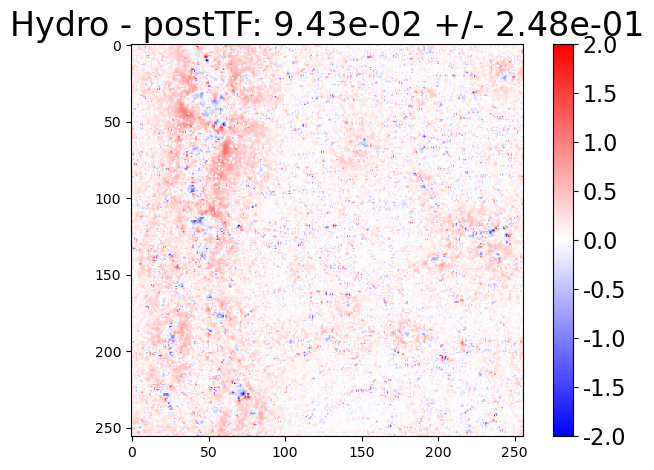

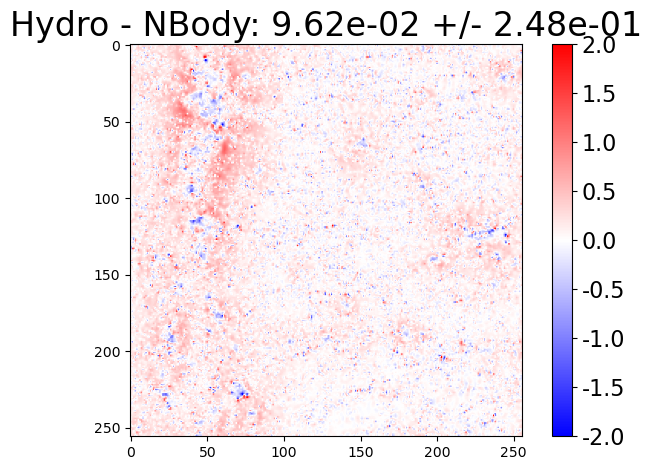

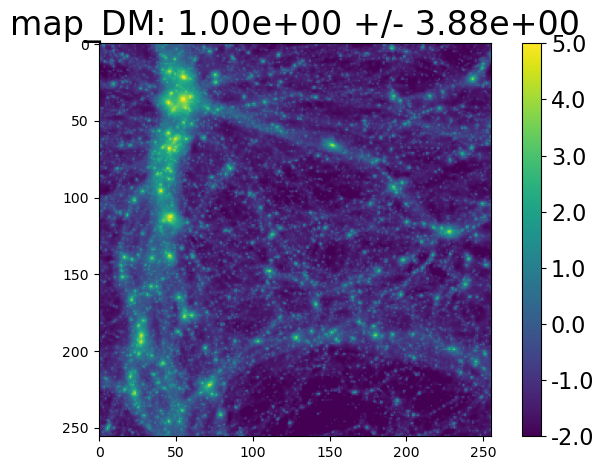

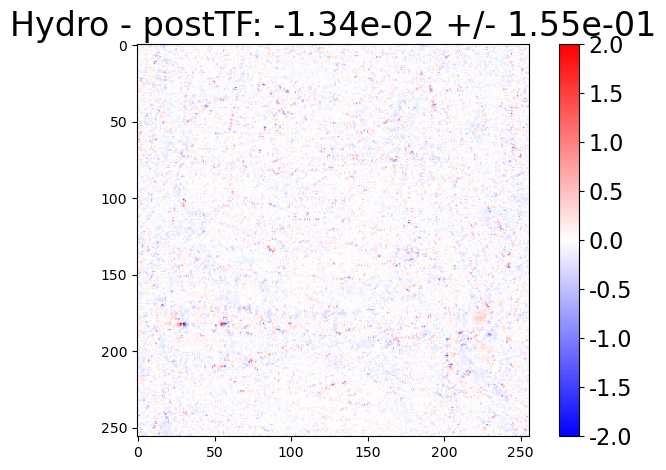

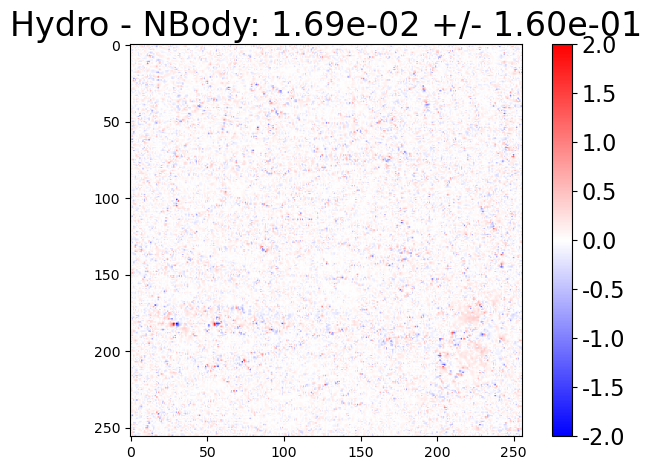

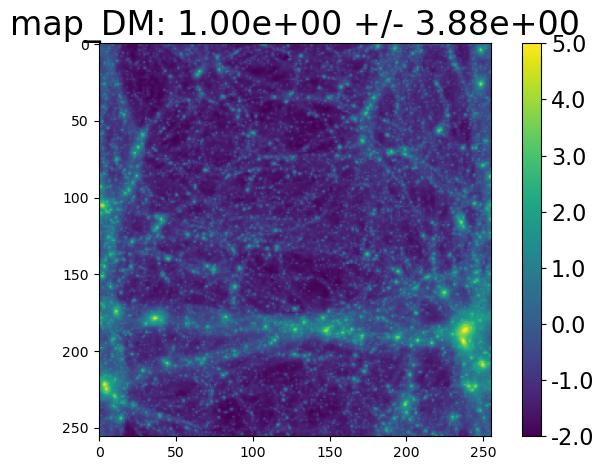

In [30]:
plot_residual_fields(10)
plot_residual_fields(9)
plot_residual_fields(3)